### Optimizing the SVM Classifier

Machine learning models are parameterized so that their behavior can be tuned for a given problem. Models can have many parameters and finding the best combination of parameters can be treated as a search problem. In this notebook, I aim to tune parameters of the SVM Classification model using scikit-learn. 

#### Load Libraries and Data

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

#Load libraries for data processing
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

## Supervised learning.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression

# visualization
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.titlesize'] = 'large'



#### Build a predictive model and evaluate with 5-cross validation using support vector classifies (ref NB4) for details



The classifier accuracy score is 0.96

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       107
           1       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



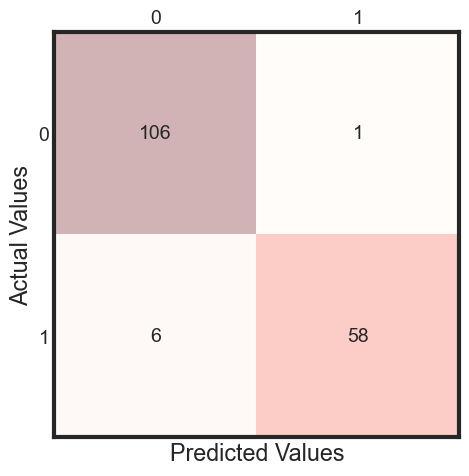

In [28]:
data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)


#Assign predictors to a variable of ndarray (matrix) type
array = data.values
X = array[:,1:31]
y = array[:,0]

#transform the class labels from their original string representation (M and B) into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Normalize the  data (center around 0 and scale to remove the variance).
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=10)
fit = pca.fit(Xs)
X_pca = pca.transform(Xs)

# 5. Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=2, stratify=y)

# 6. Create an SVM classifier and train it on 70% of the data set.
clf = SVC(probability=True)
clf.fit(X_train, y_train)

 #7. Analyze accuracy of predictions on 30% of the holdout test sample.
classifier_score = clf.score(X_test, y_test)
print ('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))

clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))
scores = cross_val_score(clf2, X_pca, y, cv=3)

# Get average of 5-fold cross-validation score using an SVC estimator.
n_folds = 5
cv_error = np.average(cross_val_score(SVC(), X_pca, y, cv=n_folds))

y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred ))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()

## Importance of optimizing a classifier

We can tune two key parameters of the SVM algorithm:
* the value of C (how much to relax the margin) 
* and the type of kernel. 

The default for SVM (the SVC class) is to use the Radial Basis Function (RBF) kernel with a C value set to 1.0. Like with KNN, we will perform a grid search using 10-fold cross validation with a standardized copy of the training dataset. We will try a number of simpler kernel types and C values with less bias and more bias (less than and more than 1.0 respectively).

Python scikit-learn provides two simple methods for algorithm parameter tuning:
 * Grid Search Parameter Tuning. 
 * Random Search Parameter Tuning.

In [29]:


# Train classifiers.
kernel_values = [ 'linear' ,  'poly' ,  'rbf' ,  'sigmoid' ]
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6),'kernel': kernel_values}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [30]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': np.float64(0.1), 'gamma': np.float64(0.001), 'kernel': 'linear'} with a score of 0.98


In [31]:
grid.best_estimator_.probability = True
clf = grid.best_estimator_

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



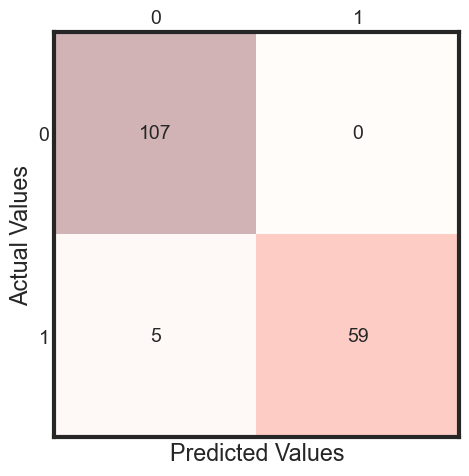

In [32]:

y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)
print(classification_report(y_test, y_pred ))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()


### Decision boundaries of different classifiers
Let's see the decision boundaries produced by the linear, Gaussian and polynomial classifiers.

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm, datasets

def decision_plot(X_train, y_train, n_neighbors, weights):
       h = .02  # step size in the mesh

Xtrain = X_train[:, :2] # we only take the first two features.

#================================================================
# Create color maps
#================================================================
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


#================================================================
# we create an instance of SVM and fit out data. 
# We do not scale ourdata since we want to plot the support vectors
#================================================================

C = 1.0  # SVM regularization parameter

svm = SVC(kernel='linear', random_state=0, gamma=0.1, C=C).fit(Xtrain, y_train)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(Xtrain, y_train)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(Xtrain, y_train)



In [34]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'
    
    # create a mesh to plot in
x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']



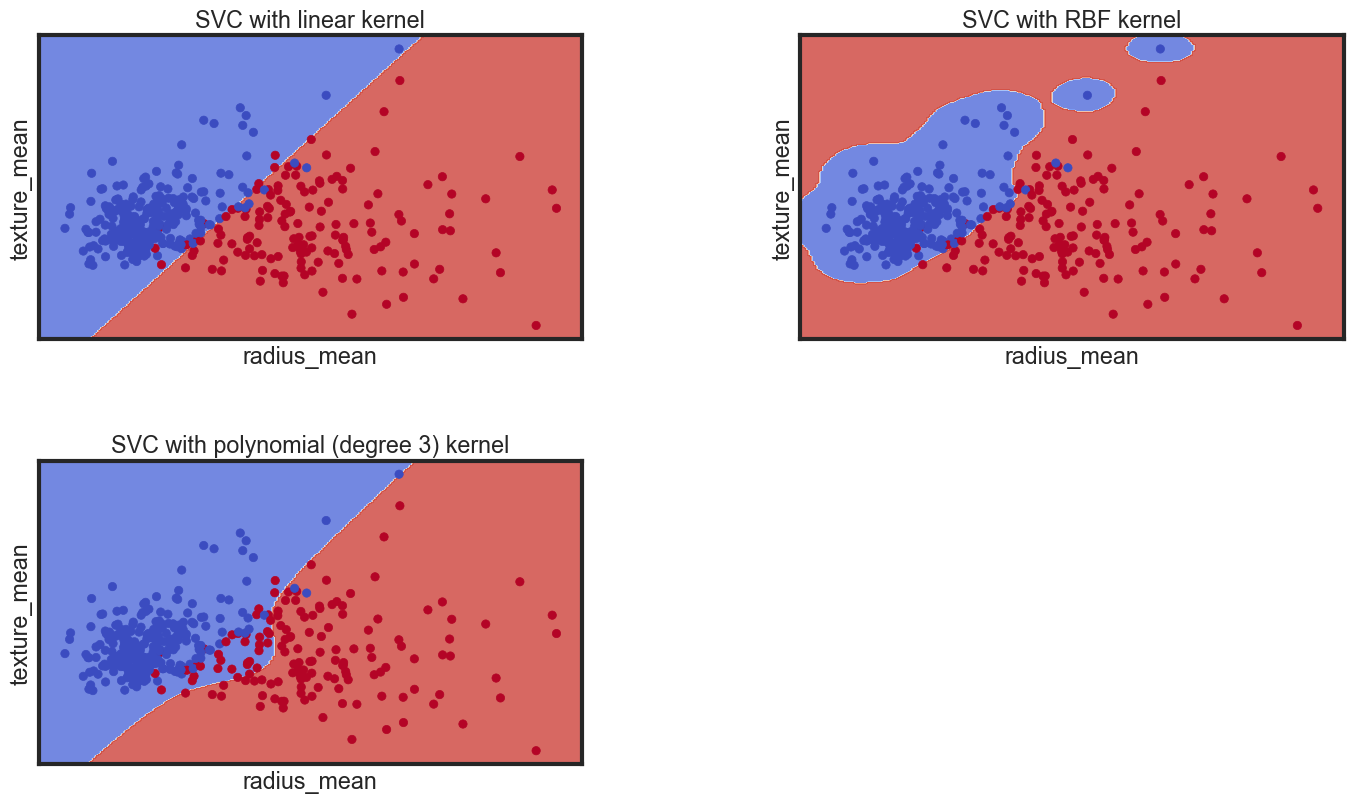

In [35]:
for i, clf in enumerate((svm, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Conclusion

This work demonstrates the modelling of breast cancer as classification task using Support Vector Machine 

The SVM performs better when the dataset is standardized so that all attributes have a mean value of zero and a standard deviation of one. We can calculate this from the entire training dataset and apply the same transform to the input attributes from the validation dataset.

Next Task:
1. Summary and conclusion of findings
2. Compare with other classification methods
   * Decision trees with tree.DecisionTreeClassifier();
   * K-nearest neighbors with neighbors.KNeighborsClassifier();
   * Random forests with ensemble.RandomForestClassifier();
   * Perceptron (both gradient and stochastic gradient) with mlxtend.classifier.Perceptron; and
   * Multilayer perceptron network (both gradient and stochastic gradient) with mlxtend.classifier.MultiLayerPerceptron.
    